<a href="https://colab.research.google.com/github/lanzizuan/suicide-attempt-prediction/blob/master/Suicide_Attempt_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data source: 
* The Demographic /r/ForeverAlone Dataset https://www.kaggle.com/kingburrito666/the-demographic-rforeveralone-dataset


![替代文字](https://storage.googleapis.com/kaggle-datasets-images/1182/2125/cda8fa2e077f32a8d5fdeb78148d0261/dataset-original.jpg)

As the economy grows and the life quality improves, the happiness, however, doesn't increase accordingly.  According to estimates from the World Health Organisation (WHO), **over 800,000** people die due to suicide every year, which means that someone dies of suicide **every 40 seconds**. Nevertheless, the tragedy can be prevented if being intervened in time.

It's important to predict whether a person has the intention to suicide so that we can take actions if needed. The suicide involves many factors, both personal and societal one.
In this notebook, I used data from a survey created by a redditor in the subreddit *ForeverAlone* which collected demographic data and whether people attempted to suicide.

![替代文字](https://ourworldindata.org/wp-content/uploads/2016/06/GenderAge-768x481.png)  

(José Manoel Bertolote and Alexandra Fleischmann, Suicide and psychiatric diagnosis: a worldwide perspective. World Psychiatry 1:3, October 2002.)

#### Survey question
1.  What is your Gender?	
2. What is your sexual orientation?	
3. How old are you?	
4. What is your level of income?	
5. What is your race?	
6. How would you describe your body/weight?	
7. Are you a virgin?	
8. Is prostitution legal where you live?	
9. Would you pay for sex?	
10. How many friends do you have in real life?
11. Do you have social anxiety/phobia?	
12. Are you depressed?	
13. What kind of help do you want from others? (Choose all that apply)	
14. Have you attempted suicide?	
15. Employment Status: Are you currently…?	
16. What is your job title?	
17. What is your level of education?	
18. What have you done to try and improve yourself? (Check all that apply)	





# 1. Ingest

## 1.1 Import Package

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib 
import numpy as np

from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from yellowbrick.features import RFECV
import statsmodels.formula.api as smf

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

## 1.2 Import Dataset

In [0]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/lanzizuan/MachineLearningCourse/master/suiside_pop.csv')
df_ind = pd.read_csv('https://raw.githubusercontent.com/lanzizuan/MachineLearningCourse/master/foreveralone.csv')

## 1.3 Data Cleaning

In [0]:
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469 entries, 0 to 468
Data columns (total 19 columns):
time                     469 non-null object
attempt_suicide          469 non-null object
gender                   469 non-null object
sexuallity               469 non-null object
age                      469 non-null int64
income                   469 non-null object
race                     469 non-null object
bodyweight               469 non-null object
virgin                   469 non-null object
prostitution_legal       469 non-null object
pay_for_sex              469 non-null object
friends                  469 non-null float64
social_fear              469 non-null object
depressed                469 non-null object
what_help_from_others    469 non-null object
employment               469 non-null object
job_title                457 non-null object
edu_level                469 non-null object
improve_yourself_how     469 non-null object
dtypes: float64(1), int64(1), object(17)

In [0]:
df_ind.head()

,time,attempt_suicide,gender,sexuallity,age,income,race,bodyweight,virgin,prostitution_legal,pay_for_sex,friends,social_fear,depressed,what_help_from_others,employment,job_title,edu_level,improve_yourself_how
0,5/17/2016 20:04:18,Yes,Male,Straight,35,"$30,000 to $39,999",White non-Hispanic,Normal weight,Yes,No,No,0.0,Yes,Yes,"wingman/wingwoman, Set me up with a date",Employed for wages,mechanical drafter,Associate degree,None
1,5/17/2016 20:04:30,No,Male,Bisexual,21,"$1 to $10,000",White non-Hispanic,Underweight,Yes,No,No,0.0,Yes,Yes,"wingman/wingwoman, Set me up with a date, date...",Out of work and looking for work,-,"Some college, no degree",join clubs/socual clubs/meet ups
2,5/17/2016 20:04:58,No,Male,Straight,22,$0,White non-Hispanic,Overweight,Yes,No,No,10.0,Yes,Yes,I don't want help,Out of work but not currently looking for work,unemployed,"Some college, no degree",Other exercise
3,5/17/2016 20:08:01,No,Male,Straight,19,"$1 to $10,000",White non-Hispanic,Overweight,Yes,Yes,No,8.0,Yes,Yes,date coaching,A student,student,"Some college, no degree",Joined a gym/go to the gym
4,5/17/2016 20:08:04,No,Male,Straight,23,"$30,000 to $39,999",White non-Hispanic,Overweight,No,No,Yes and I have,10.0,No,Yes,I don't want help,Employed for wages,Factory worker,"High school graduate, diploma or the equivalen...",None


In [0]:
cols = ['what_help_from_others', 'improve_yourself_how','job_title']
df_ind.drop(['time'],axis = 1,inplace = True)
df = df_ind.drop(cols,axis = 1)

## 1.4 Feature encoding

Print out values and count of categorical fields. Note that race contains many values, which might need extra processing, so we don't use it to predict for now.

In [0]:
cate_col = ['gender', 'sexuallity', 'race', 'bodyweight', 'employment', 'edu_level', 'income']
bin_col = ['virgin', 'prostitution_legal', 'pay_for_sex', 'social_fear', 'depressed']
text_col = ['job_title', 'what_help_from_others', 'improve_yourself_how']

pivot = ['gender', 'sexuallity', 'race', 'bodyweight', 'employment', 'edu_level',
         'income','virgin', 'prostitution_legal', 'pay_for_sex', 'social_fear',
         'depressed']
Target = ['attempt_suicide']

In [0]:
for i in cate_col:
  print(df[i].value_counts())
  print('---------------')

Male                  393
Female                 73
Transgender male        2
Transgender female      1
Name: gender, dtype: int64
---------------
Straight       415
Bisexual        46
Gay/Lesbian      8
Name: sexuallity, dtype: int64
---------------
White non-Hispanic                                                                 336
Asian                                                                               54
Hispanic (of any race)                                                              32
Black                                                                               22
Mixed                                                                                3
Indian                                                                               2
Middle Eastern                                                                       2
Turkish                                                                              1
half Arab                                            

The following features wil be used as predictor variable
 * Categorical: 
  * Multi Class: gender, sexuallity, race, bodyweight, employment,  edu_level, income
  *  Binery(yes/no): virgin, prostitution_legal, pay_for_sex,  social_fear, depressed
 * Numerical:  age, friends

The text fields (job_title, what_help_from_others, improve_yourself_how) will be used to create word cloud.

Convert Target Variable to 0/1

In [0]:
df['attempt_suicide'] = np.where(df['attempt_suicide'].str.contains("Yes"),1,0)

### Pivot Table

Print out correlation between categorical variable and target variable as pivot table. The number is probability of attempting suicide.

In [0]:
for x in pivot:
        print('Survival Correlation by:', x)
        print(df[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by: gender
               gender  attempt_suicide
0              Female         0.301370
1                Male         0.155216
2  Transgender female         1.000000
3    Transgender male         0.500000
---------- 

Survival Correlation by: sexuallity
    sexuallity  attempt_suicide
0     Bisexual         0.413043
1  Gay/Lesbian         0.375000
2     Straight         0.151807
---------- 

Survival Correlation by: race
                                                 race  attempt_suicide
0                                               Asian         0.129630
1                                               Black         0.409091
2                                            European         1.000000
3   First two answers. Gender is androgyne, not ma...         1.000000
4                               Half Asian half white         0.000000
5                              Hispanic (of any race)         0.312500
6                                              Indian   

In [0]:
ba = df['edu_level'].str.startswith('Ba')
df.loc[ba,'edu_level'] = 'Bachlor\'s Degree'

ma = df['edu_level'].str.startswith('Ma')
df.loc[ma,'edu_level'] = 'Master\'s Degree'

### Encode the categorical numerical values

In [0]:
encoding = {'income': {'$0': 0,'$1 to $10,000': 1,
                      '$10,000 to $19,999': 2, '$20,000 to $29,999': 3,
                     '$30,000 to $39,999': 4, '$40,000 to $49,999': 5,
                     '$50,000 to $74,999': 6, '$75,000 to $99,999': 7,
                     '$100,000 to $124,999': 8, '$125,000 to $149,999': 9,
                     '$150,000 to $174,999': 10,  '$174,999 to $199,999': 11,
                     '$200,000 or more':12 },
           'edu_level': {'Some high school, no diploma': 0, 
                         'High school graduate, diploma or the equivalent (for example: GED)': 1,
                         'Trade/technical/vocational training': 2, 
                         'Some college, no degree': 3,'Associate degree': 4,
                         'Bachlor\'s Degree': 5,'Master\'s Degree':6,
                        'Doctorate degree': 7,'Professional degree':8 },
           'bodyweight': {'Underweight': 0, 'Normal weight' : 1,'Overweight' : 2,
                         'Obese': 3 }
           }

df.replace(encoding, inplace=True)


### Create dummy variable

In [0]:
dummy_col = ['gender', 'sexuallity','employment']
df = pd.get_dummies(df,columns = dummy_col, prefix = ['gender', 'sexuallity','employment'])

### Encode binary variable

In [0]:
bin_col = ['virgin', 'prostitution_legal', 'pay_for_sex', 'social_fear', 'depressed']

for i in bin_col:
  df[i] = np.where(df[i].str.contains("Yes"),1,0)

In [0]:
df.head()

,attempt_suicide,age,income,race,bodyweight,virgin,prostitution_legal,pay_for_sex,friends,social_fear,...,sexuallity_Straight,employment_A homemaker,employment_A student,employment_Employed for wages,employment_Military,employment_Out of work and looking for work,employment_Out of work but not currently looking for work,employment_Retired,employment_Self-employed,employment_Unable to work
0,1,35,4,White non-Hispanic,1,1,0,0,0.0,1,...,1,0,0,1,0,0,0,0,0,0
1,0,21,1,White non-Hispanic,0,1,0,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,22,0,White non-Hispanic,2,1,0,0,10.0,1,...,1,0,0,0,0,0,1,0,0,0
3,0,19,1,White non-Hispanic,2,1,1,0,8.0,1,...,1,0,1,0,0,0,0,0,0,0
4,0,23,4,White non-Hispanic,2,0,0,1,10.0,0,...,1,0,0,1,0,0,0,0,0,0


# 2. Exploratory Data Analysis

### Scatter Plot

Create scatter plot of continous numerical varibles to see whether there is anomaly

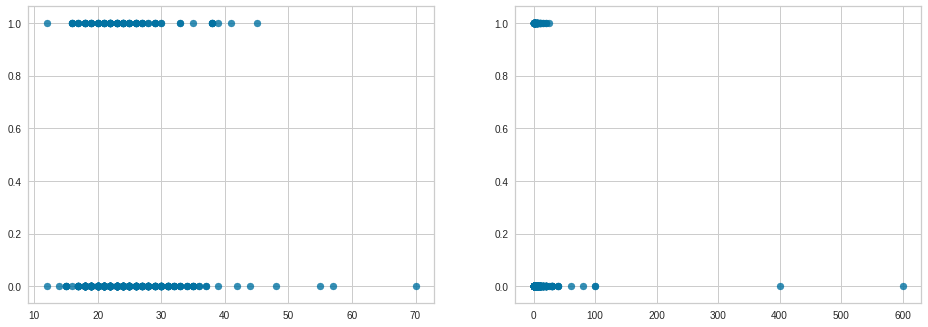

In [0]:
plt.figure(figsize=[16,12])

plt.subplot(221)
plt.scatter(df['age'],df['attempt_suicide'],alpha = 0.8)

plt.subplot(222)
plt.scatter(df['friends'],df['attempt_suicide'],alpha = 0.8)

Remove the anomaly

In [0]:
df = df[df['friends']<200]

### Box Plot and Stacked Histogram

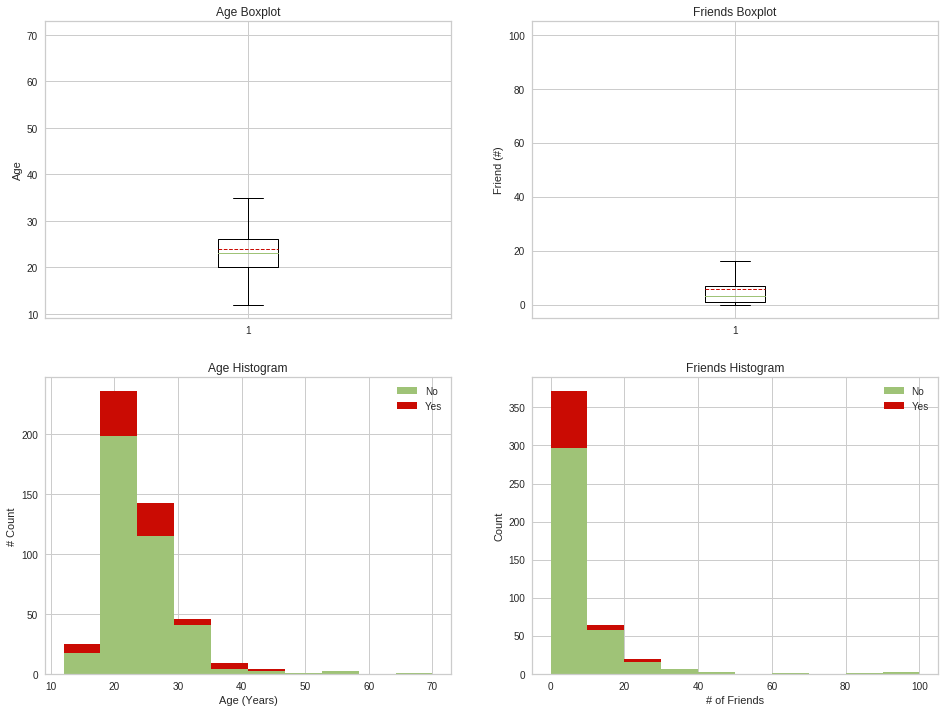

In [0]:
plt.figure(figsize=[16,12])

plt.subplot(221)
plt.boxplot(x=df['age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age')


plt.subplot(222)
plt.boxplot(x=df['friends'], showmeans = True, meanline = True)
plt.title('Friends Boxplot')
plt.ylabel('Friend (#)')

plt.subplot(223)
plt.hist(x = [df[df['attempt_suicide']==0]['age'], df[df['attempt_suicide']==1]['age']], 
         stacked=True, color = ['g','r'],label = ['No','Yes'])

plt.title('Age Histogram')
plt.xlabel('Age (Years)')
plt.ylabel('# Count')
plt.legend()

plt.subplot(224)
plt.hist(x = [df[df['attempt_suicide']==0]['friends'], df[df['attempt_suicide']==1]['friends']], 
         stacked=True, color = ['g','r'],label = ['No','Yes'])
plt.title('Friends Histogram')
plt.xlabel('# of Friends')
plt.ylabel('Count')
plt.legend()

In [0]:
df.groupby(Target).mean()

,age,income,bodyweight,virgin,prostitution_legal,pay_for_sex,friends,social_fear,depressed,edu_level,...,sexuallity_Straight,employment_A homemaker,employment_A student,employment_Employed for wages,employment_Military,employment_Out of work and looking for work,employment_Out of work but not currently looking for work,employment_Retired,employment_Self-employed,employment_Unable to work
attempt_suicide,,,,,,,,,,,,,,,,,,,,,
0,23.871728,2.062827,1.180628,0.759162,0.230366,0.321990,6.312042,0.633508,0.620419,3.217277,...,0.918848,0.007853,0.382199,0.374346,0.013089,0.062827,0.086387,0.007853,0.044503,0.020942
1,24.247059,1.882353,1.329412,0.717647,0.235294,0.329412,3.770588,0.776471,0.882353,2.541176,...,0.741176,0.000000,0.329412,0.305882,0.000000,0.164706,0.082353,0.000000,0.058824,0.058824


### Barchart and Stacked barchart of Categorical/Numerical Variables

<Figure size 576x432 with 0 Axes>

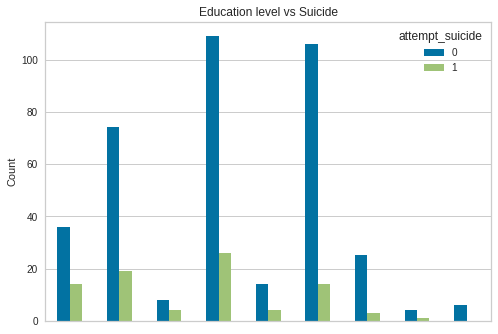

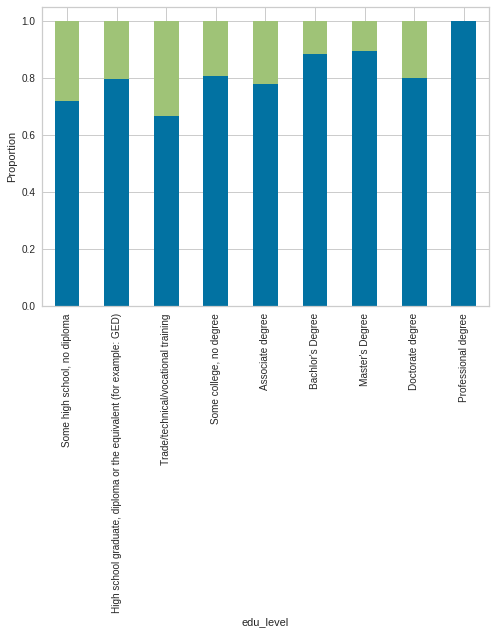

In [0]:
plt.figure(figsize=[8,6])


ax1 =pd.crosstab(df['edu_level'],df['attempt_suicide']).plot(kind='bar')
plt.title('Education level vs Suicide')
plt.ylabel('Count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.axes.get_xaxis().set_visible(False)


N = df['edu_level'].nunique()
ind = np.arange(N)
table=pd.crosstab(df['edu_level'],df['attempt_suicide'])
ax2 = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('edu_level')
plt.ylabel('Proportion')
plt.xticks(ind, encoding['edu_level'].keys())
ax2.get_legend().remove()
plt.show()





<Figure size 576x432 with 0 Axes>

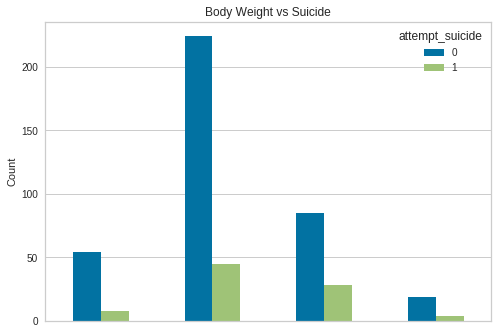

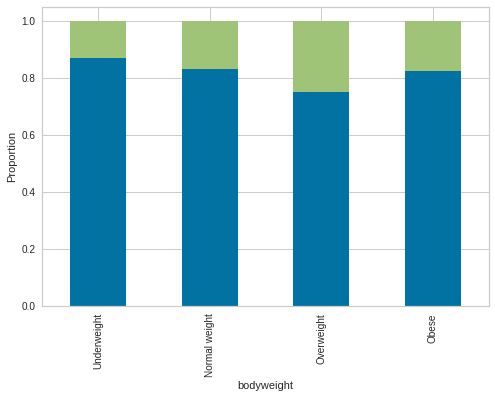

In [0]:
plt.figure(figsize=[8,6])

ax1 =pd.crosstab(df['bodyweight'],df['attempt_suicide']).plot(kind='bar')
plt.title('Body Weight vs Suicide')
plt.ylabel('Count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.axes.get_xaxis().set_visible(False)


N = df['bodyweight'].nunique()
ind = np.arange(N)
table=pd.crosstab(df['bodyweight'],df['attempt_suicide'])
ax2 = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('bodyweight')
plt.ylabel('Proportion')
plt.xticks(ind, encoding['bodyweight'].keys())
ax2.get_legend().remove()
plt.show()

<Figure size 576x432 with 0 Axes>

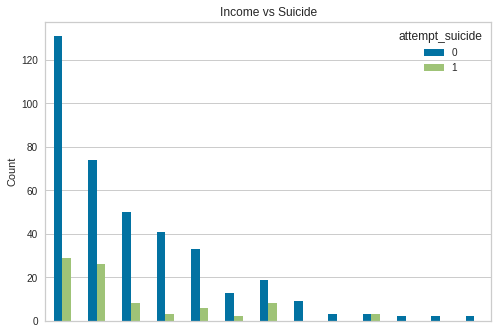

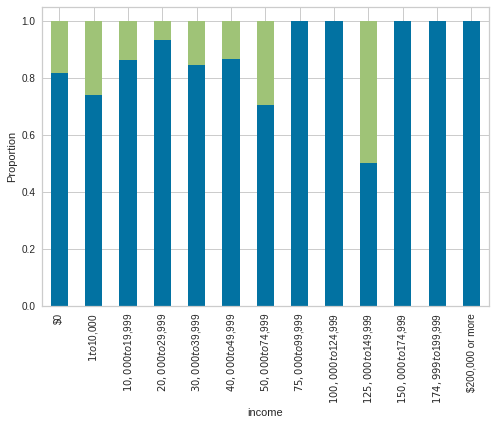

In [0]:
plt.figure(figsize=[8,6])
ax1 =pd.crosstab(df['income'],df['attempt_suicide']).plot(kind='bar')
plt.title('Income vs Suicide')
plt.ylabel('Count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.axes.get_xaxis().set_visible(False)


N = df['income'].nunique()
ind = np.arange(N)
table=pd.crosstab(df['income'],df['attempt_suicide'])
ax2 = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('income')
plt.ylabel('Proportion')
plt.xticks(ind, encoding['income'].keys())
ax2.get_legend().remove()
plt.show()

### Wordcloud 

word cloud of what help from others for those who attempted to suicide

In [0]:
suicide =df_ind['attempt_suicide'] =='Yes'
df_suicide = df_ind.loc[suicide,'what_help_from_others']
df_suicide_job = df_ind.loc[suicide,'job_title']

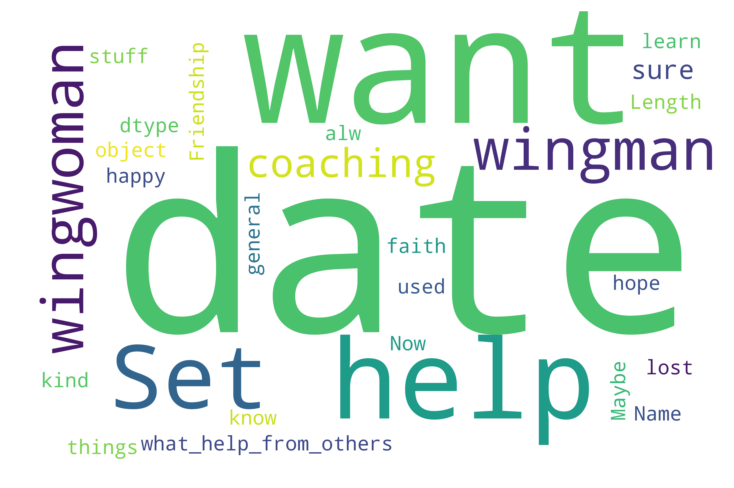

In [0]:
import os

from os import path
from wordcloud import WordCloud, STOPWORDS


# Read the whole text.
text = str(df_suicide)
text1 = str(df_suicide_job)
# Generate a word cloud image
#wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS,collocations=False).generate(str(text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

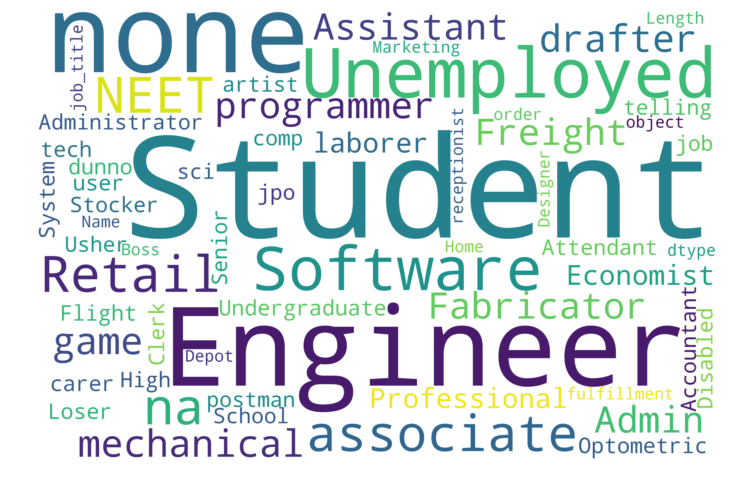

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS,collocations=False).generate(str(text1))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Heatmap

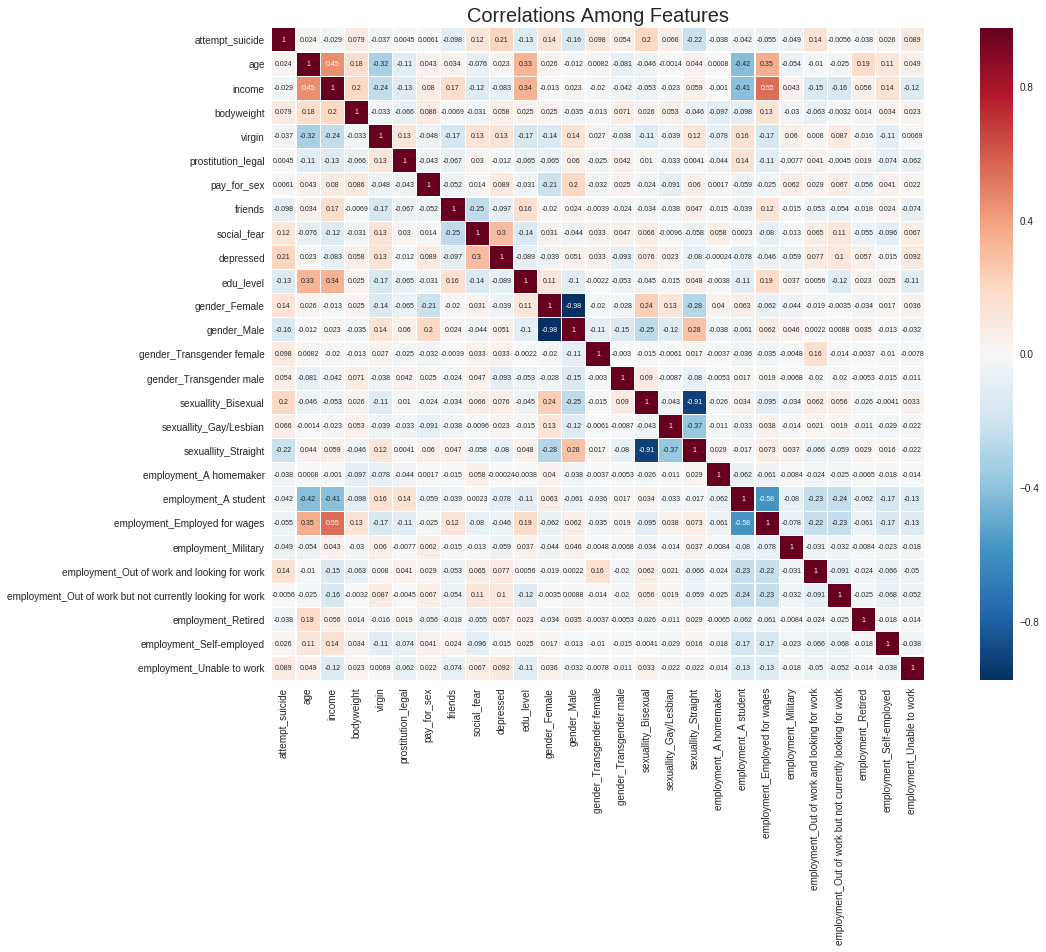

In [0]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (20,12))
sns.heatmap(df.corr(), 
            annot=True,
            annot_kws={"size": 7},
            #mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

### Observation

* Straight(-0.22), depressed(0.21), Bisexual(0.2) has the highest correlation with suicide.

# 3. Modeling

## 3.0 Pre-Modeling Task

### 3.0.1 Split training/test set

In [0]:
X = df.drop(['attempt_suicide','race'], axis = 1)
y = df['attempt_suicide']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42, stratify=y)

### 3.0.2 Over-Sampling Using SMOTE(Synthetic Minority Oversampling Technique) 

As the proportion of attempt/not attempt to suicide is imbalanced in the dataset, we can oversample using SMOTE to adjust the proportion.  

 At a high level, SMOTE:

* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [0]:
os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not attempt to suicide in oversampled data is ",len(os_data_y[os_data_y['y']==0]))
print("Number of attempt to suicide is ",len(os_data_y[os_data_y['y']==1]))
print("Proportion of not attempt to suicide in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of attempt to suicide in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))


length of oversampled data is  510
Number of not attempt to suicide in oversampled data is  255
Number of attempt to suicide is  255
Proportion of not attempt to suicide in oversampled data is  0.5
Proportion of attempt to suicide in oversampled data is  0.5


### 3.0.3 Feature Selection Using Recursive Feature Elimination (RFE) 

RFE is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

#### Yellow Brick RFE Visualizer

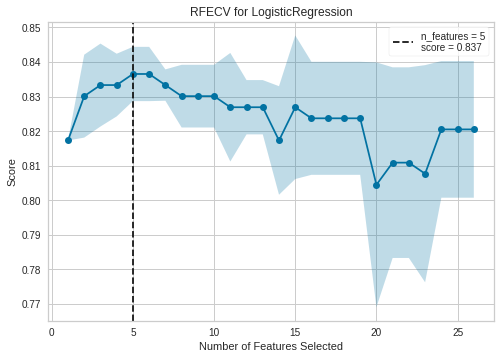

In [0]:
logreg = LogisticRegression()
viz = RFECV(logreg, cv=3, scoring='accuracy')
viz.fit(X_train, y_train)
viz.poof()

#### RFE

Enter number of features that we want to keep. Can be obtained from visualizer. However, the number that visualizer gave is 5, which seems too small and might filter out a large amount of information.

 Therefore, except for 5, I choose 18 as a test number because there are 9 fields before encoding and I feel I should keep at least two for each field.

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

def rfe_loop(num):

  rfe = RFE(logreg,num)
  rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
  wrap = rfe.support_
  global X_train
  ori =X_train.columns.tolist()
  wrapped = pd.DataFrame({'ori':ori, 'wrap': wrap})
  wrapped1 = wrapped[wrapped['wrap']==True]
  imp_col = wrapped1['ori']
  X_train_train = os_data_X[imp_col]
  y_train_train = os_data_y['y']
  logit_model=smf.Logit(y_train_train, X_train_train)
  result=logit_model.fit() 
  

  print(result.summary2())

In [0]:
rfe_loop(18)

         Current function value: 0.468933
         Iterations: 35
                                                    Results: Logit
Model:                                 Logit                              No. Iterations:                     35.0000 
Dependent Variable:                    y                                  Pseudo R-squared:                   0.323   
Date:                                  2019-02-23 00:05                   AIC:                                514.3121
No. Observations:                      510                                BIC:                                590.5315
Df Model:                              17                                 Log-Likelihood:                     -239.16 
Df Residuals:                          492                                LL-Null:                            -353.51 
Converged:                             0.0000                             Scale:                              1.0000  
----------------------------------

Filter out unimportant features, keep significant ones(p<0.1)

In [0]:
final_col = ['income', 'bodyweight',  'depressed', 'edu_level','gender_Male',
             'sexuallity_Straight','employment_Unable to work']
X_train_train = os_data_X[final_col]
y_train_train = os_data_y['y']
logit_model=smf.Logit(y_train_train, X_train_train)
result=logit_model.fit() 
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.495151
         Iterations 7
                             Results: Logit
Model:                  Logit               No. Iterations:      7.0000  
Dependent Variable:     y                   Pseudo R-squared:    0.286   
Date:                   2019-02-23 00:05    AIC:                 519.0542
No. Observations:       510                 BIC:                 548.6951
Df Model:               6                   Log-Likelihood:      -252.53 
Df Residuals:           503                 LL-Null:             -353.51 
Converged:              1.0000              Scale:               1.0000  
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
income                     0.2031   0.0561  3.6194 0.0003  0.0931  0.3130
bodyweight                 0.5114   0.14

In [0]:
final_col = ['income', 'bodyweight',  'depressed', 'edu_level','gender_Male',
             'sexuallity_Straight']
X_train_train = os_data_X[final_col]
y_train_train = os_data_y['y']
logit_model=smf.Logit(y_train_train, X_train_train)
result=logit_model.fit() 
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.497759
         Iterations 7
                          Results: Logit
Model:                Logit             No. Iterations:    7.0000  
Dependent Variable:   y                 Pseudo R-squared:  0.282   
Date:                 2019-02-23 00:05  AIC:               519.7139
No. Observations:     510               BIC:               545.1203
Df Model:             5                 Log-Likelihood:    -253.86 
Df Residuals:         504               LL-Null:           -353.51 
Converged:            1.0000            Scale:             1.0000  
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
income               0.1933   0.0557  3.4680 0.0005  0.0840  0.3025
bodyweight           0.5365   0.1487  3.6079 0.0003  0.2451  0.8280
depressed            2.8929   0.3266  8.8

## 3.1 Logistic Regression

In [0]:
X = os_data_X[final_col]
X_test = X_test[final_col]
X = pd.concat([X,X_test])

y = os_data_y['y']
y = pd.concat([y,y_test])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

logreg = LogisticRegression()
logreg.fit(X, y)

y_pred = logreg.predict(X_test)
logreg_accy_train = round(logreg.score(X_train, y_train),2)
logreg_accy = round(logreg.score(X_test, y_test),2)


In [0]:
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg_accy_train))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_accy))

Accuracy of logistic regression classifier on training set: 0.73
Accuracy of logistic regression classifier on test set: 0.68


## 3.2 KNN Classifier

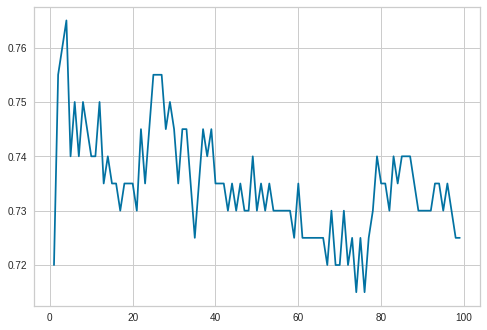

In [0]:
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import mean_absolute_error, accuracy_score

## choosing the best n_neighbors
nn_scores = []

best_prediction = [-1,-1]

for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='minkowski', p =2)
    knn.fit(X_train,y_train)
    score = accuracy_score(y_test, knn.predict(X_test))
    
    #print i, score
    if score > best_prediction[1]:
        best_prediction = [i, score]
    nn_scores.append(score)
    

knn_best = KNeighborsClassifier(n_neighbors= best_prediction[0], weights='distance', metric='minkowski', p =2)
knn_best.fit(X_train,y_train)
knn_accy_train = round(accuracy_score(y_test, knn.predict(X_test)),2)
knn_accy = round(best_prediction[1],2)    

                                 
plt.plot(range(1,100),nn_scores)

In [0]:
print ('The best number of neighbors is: {:.0f}'.format(best_prediction_knn[0]))
print ('Accuracy of KNN classifier on training set: {:.2f}'.format(knn_accy_train))
print ('Accuracy of KNN classifier on test set: {:.2f}'.format(knn_accy))

The best number of neighbors is: 4
Accuracy of KNN classifier on training set: 0.72
Accuracy of KNN classifier on test set: 0.76


### GridSearch CV on KNN

In [0]:
n_neighbors=[1,2,3,4,5,6,7,8,9,10]
weights=['uniform','distance']
param = {'n_neighbors':n_neighbors, 
         'weights':weights}
grid2 = GridSearchCV(knn, 
                     param,
                     verbose=False, 
                     cv=StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
                    )
grid2.fit(X_train, y_train)

knn_grid = grid2.best_estimator_
knn_grid_accy_train = round(grid2.best_score_,2)
knn_grid_accy = round(knn_grid.score(X_test, y_test),2)

In [0]:
print (grid2.best_params_)
print ('Accuracy of KNN classifier GridSearch CV on training set: {:.2f}'.format(knn_grid_accy_train))
print ('Accuracy of KNN classifier GridSearch CV on test set: {:.2f}'.format(knn_grid_accy ))

{'n_neighbors': 2, 'weights': 'distance'}
Accuracy of KNN classifier GridSearch CV on training set: 0.82
Accuracy of KNN classifier GridSearch CV on test set: 0.76


## 3.3 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100,max_depth=9,min_samples_split=6, min_samples_leaf=4)
#randomforest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
random_accy_train = round(accuracy_score(randomforest.predict(X_train), y_train), 2)
random_accy = round(accuracy_score(y_pred, y_test), 2)



In [0]:
print ('Accuracy of Random Forest GridSearch CV on training set: {:.2f}'.format(random_accy_train))
print ('Accuracy of Random Forest GridSearch CV on test set: {:.2f}'.format(random_accy))

Accuracy of Random Forest GridSearch CV on training set: 0.91
Accuracy of Random Forest GridSearch CV on test set: 0.80


### GridSearch CV on Random Forest

In [0]:
n_estimators = [100,120]
max_depth = range(1,30)



parameters = {'n_estimators':n_estimators, 
         'max_depth':max_depth, 
        }
randomforest_grid = GridSearchCV(randomforest,
                                 param_grid=parameters,
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                 n_jobs = -1
                                )

randomforest_grid.fit(X_train, y_train) 
random_grid_accy_train = round(randomforest_grid.score(X_train, y_train),2)
random_grid_accy = round(randomforest_grid.score(X_test, y_test),2)

In [0]:
print ('Accuracy of Random Forest GridSearch CV on training set: {:.2f}'.format(random_grid_accy_train))
print ('Accuracy of Random Forest GridSearch CV on test set: {:.2f}'.format(random_grid_accy))

Accuracy of Random Forest GridSearch CV on training set: 0.89
Accuracy of Random Forest GridSearch CV on test set: 0.81


## Model Persormance Summary

In [0]:
performance = {'Logistic Regression':[logreg_accy_train, logreg_accy],
              'KNN Classifier':[knn_accy_train, knn_accy],
              'KNN Classifier Grid Search CV':[knn_grid_accy_train, knn_grid_accy],
              'Random Forest':[random_accy_train,random_accy],
              'Random Forest Grid Search CV' :[random_grid_accy_train,random_grid_accy]}


In [0]:
df_performance = pd.DataFrame.from_dict(performance, orient = 'index')
df_performance.columns=['Accuracy on Training Set','Accuracy on Test Set']

In [0]:
df_performance

,Accuracy on Training Set,Accuracy on Test Set
Logistic Regression,0.73,0.68
KNN Classifier,0.72,0.76
KNN Classifier Grid Search CV,0.82,0.76
Random Forest,0.91,0.80
Random Forest Grid Search CV,0.89,0.81


## 4. Conclusion

### About Suicide

 Based on the survey, six features have influence on one's intention to suicide:
  
 * depressed (2.8929) 
 * sexuallity_Straight (-2.0080) 
 * gender_Male （-1.0198）
 * body weight (0.5365) 
 * edu_level (-0.3293) 
 * income (0.1933)


### About Modeling

During the process of feature selection and model selection, it's not necessary to find the best one, but a good enough one.
* The RFE visualizer show that a logistic regression model with 5 features will be the best accurate one. Considering the complexity of suicide, some important information might lose if I only keep 5 features.


### Next Step

* Try out different ways to encode categorical variables. (gender_male has negative coefficient obeys the common sense.)
* Used the important features gotten from this analysis to analyze people's post on twitter or reddit to find out people who tend to suicide and make some intervention.